In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/NLP

/content/drive/MyDrive/NLP


In [ ]:
pip install transformers==2.6.0

Opening and Reading Training data


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("bert.txt", sep="\t").fillna(method="ffill")
data['tag'][0] = 'B-Chemical'
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Sent_ID         Word         tag
0        0   Selegiline  B-Chemical
1        0            -           O
2        0      induced           O
3        0     postural   B-Disease
4        0  hypotension   I-Disease

Opening and reading validation data

In [ ]:
val_data = pd.read_csv("bert_val.txt", sep="\t").fillna(method="ffill")
val_data[:10]

##Preprocessing 

Segregating the training data sentence-wise

In [ ]:
class GetSentence(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
     
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("Sent_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = GetSentence(data)
v_getter = GetSentence(val_data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]
v_sentences = [[word[0] for word in sentence] for sentence in v_getter.sentences]


Extracting labels separately

In [ ]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])
v_labels = [[s[1] for s in sentence] for sentence in v_getter.sentences]
v_labels[0]


In [ ]:
tag_values = list(set(data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

#Adding Padding at the end of each sentence

v_tag_values = list(set(val_data["tag"].values))
v_tag_values.append("PAD")
v_tag2idx = {t: i for i, t in enumerate(tag_values)}

In [ ]:
tag_values

['O', 'B-Chemical', 'I-Disease', 'I-Chemical', 'B-Disease', 'PAD']

Preprocessing the sentence and labels to use with pytorch and transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, AlbertTokenizer, AlbertConfig, RobertaConfig, RobertaTokenizer, AutoTokenizer

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.10.0+cu111'

Setting Batch size and sequence length

In [ ]:
MAX_LEN = 75
bs = 32
#batch size = bs


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)


'Tesla K80'

Initializing Tokenizer according to the appropriate transformer model

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False) 

# tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False) 

tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", do_lower_case=True)

# tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1", do_lower_case=False)


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/225k [00:00<?, ?B/s]

Tokenizing sentences

In [ ]:

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenizing the word
        tokenized_wingord = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Adding the tokenized word to a tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to a label list
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels 


In [ ]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]
v_tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(v_sentences, v_labels)
]

In [ ]:
tokenized_texts_and_labels[0]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

v_tokenized_texts = [token_label_pair[0] for token_label_pair in v_tokenized_texts_and_labels]
v_labels = [token_label_pair[1] for token_label_pair in v_tokenized_texts_and_labels]

In [ ]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

v_input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in v_tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [ ]:
len(labels)

4560

In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

v_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in v_labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
# initializing attenation masks 
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

v_attention_masks = [[float(i != 0.0) for i in ii] for ii in v_input_ids]

In [ ]:
attention_masks

Validation data split from training data

In [ ]:

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

This cell can be run this for a separate validation set that is not split from the training data

In [ ]:
tr_inputs = input_ids
val_inputs = v_input_ids
tr_tags = tags
val_tags = v_tags
tr_masks = attention_masks
val_masks = v_attention_masks

Converting input to torch tensors

In [ ]:

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


In [ ]:

#shuffling training data
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


#Fine Tuning

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW, AlbertForTokenClassification, RobertaForTokenClassification, AutoModelForTokenClassification, AutoConfig

transformers.__version__


'2.6.0'

Initializing and loading the Pretrained Transformer language model from the HuggingFace Library

In [ ]:
# model = BertForTokenClassification.from_pretrained(
#     "bert-base-cased",
#     num_labels=len(tag2idx),
#     output_attentions = False,
#     output_hidden_states = False
# )

# model = AlbertForTokenClassification.from_pretrained(
#     "albert-base-v1",
#     num_labels=len(tag2idx),
#     output_attentions = False,
#     output_hidden_states = False
# )

# model = RobertaForTokenClassification.from_pretrained(
#     "roberta-base",
#     num_labels=len(tag2idx),
#     output_attentions = False,
#     output_hidden_states = False
# )

model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
# model_name = "bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16"

# model_name = "dmis-lab/biobert-base-cased-v1.1"

config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(tag2idx)
config.output_attentions = False
config.output_hidden_states = False
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    config=config
)



Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
model.cuda();

Fine-tuning 

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)


In [ ]:
#setting learning rate and number of steps
from transformers import get_linear_schedule_with_warmup

epochs = 8
max_grad_norm = 1.0

total_steps = len(train_dataloader) * epochs


scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

Fit bert for ner

In [ ]:
!pip install seqeval


In [ ]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


Fine-tuning on the tranformer model

In [ ]:
## Storing the average loss after each epoch 
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    

    # Putting the model into training mode.
    model.train()
    
    total_loss = 0

    
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()

   
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


  

    # Validation after each training step
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        
        eval_loss += outputs[0].mean().item()
        eval_accuracy += flat_accuracy(logits, label_ids)
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/8 [00:00<?, ?it/s]

Average train loss: 0.2258493368939836


Epoch:  12%|█▎        | 1/8 [01:54<13:18, 114.06s/it]

Validation loss: 0.08162307565410933
Validation Accuracy: 0.33869444444444446
Validation F1-Score: 0.8680373831775701

Average train loss: 0.06482879066652106


Epoch:  25%|██▌       | 2/8 [03:47<11:22, 113.82s/it]

Validation loss: 0.05600529151658217
Validation Accuracy: 0.34211111111111114
Validation F1-Score: 0.9207576343254735

Average train loss: 0.033753988210314


Epoch:  38%|███▊      | 3/8 [05:41<09:28, 113.78s/it]

Validation loss: 0.05850631271799405
Validation Accuracy: 0.3419444444444445
Validation F1-Score: 0.9257142857142858

Average train loss: 0.01905732480231528


Epoch:  50%|█████     | 4/8 [07:35<07:34, 113.70s/it]

Validation loss: 0.06343692075461149
Validation Accuracy: 0.3423055555555556
Validation F1-Score: 0.9364651520985753

Average train loss: 0.011427942251465319


Epoch:  62%|██████▎   | 5/8 [09:28<05:40, 113.66s/it]

Validation loss: 0.07044846328596274
Validation Accuracy: 0.3430555555555556
Validation F1-Score: 0.9414955443626501

Average train loss: 0.007230493461834122


Epoch:  75%|███████▌  | 6/8 [11:22<03:47, 113.61s/it]

Validation loss: 0.06898140671352546
Validation Accuracy: 0.34341666666666665
Validation F1-Score: 0.9490470633994555

Average train loss: 0.004764618991437375


Epoch:  88%|████████▊ | 7/8 [13:15<01:53, 113.64s/it]

Validation loss: 0.07596090917165081
Validation Accuracy: 0.3432777777777778
Validation F1-Score: 0.9472049689440993

Average train loss: 0.004001128122024599


Epoch: 100%|██████████| 8/8 [15:09<00:00, 113.68s/it]

Validation loss: 0.07698944254467885
Validation Accuracy: 0.3432222222222222
Validation F1-Score: 0.9447663190421013



Plotting the training and validation loss curve

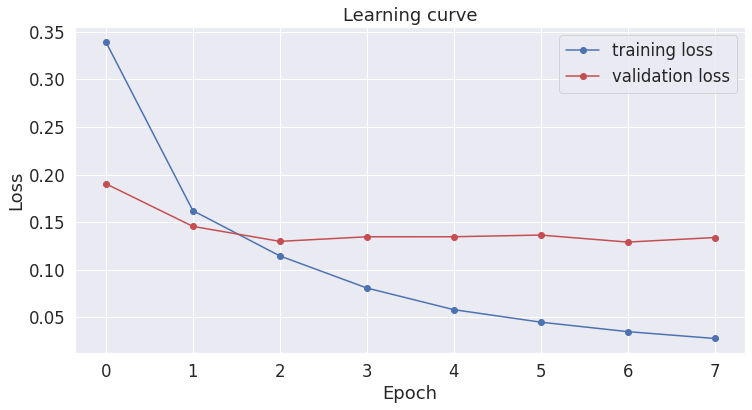

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")


plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


Testing the fine-tuned model on a sample sentence to detect entities

In [ ]:
# test_sentence = """
# SUBJECTIVE :This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time but then seemed to lose effectiveness. She has used Allegra also. She used that last summer and she began using it again two weeks ago. It does not appear to be working very well. She has used over-the-counter sprays but no prescription nasal sprays. She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: She has no known medicine allergies.,OBJECTIVE:,Vitals: Weight was 130 pounds and blood pressure 124/78.,HEENT: Her throat was mildly erythematous without exudate. Nasal mucosa was erythematous and swollen. Only clear drainage was seen. TMs were clear.,Neck: Supple without adenopathy.,Lungs: Clear.,ASSESSMENT :Allergic rhinitis.,PLAN:,1. She will try Zyrtec instead of Allegra again. Another option will be to use loratadine. She does not think she has prescription coverage so that might be cheaper.,2. Samples of Nasonex two sprays in each nostril given for three weeks. A prescription was written as well.
# """
test_sentence = " Androgen deprivation therapy (ADT) is the primary treatment for metastatic prostate cancer (PCa). However, most PCa patients receiving ADT develop recurrent castration-resistant prostate cancer (CRPC) within 3 years, with a median overall survival time of 1–2 years [1, 2]. Docetaxel is a commonly used cancer chemotherapy drug which belongs to the taxane class. Docetaxel is a synthetic analogue of paclitaxel, an extract from the bark of the rare Taxus brevifolia [3]. Docetaxel binds to the β-tubulin subunit of the microtubules, stabilizes the microtubule assembly, and prevents the depolymerization and disassembly of microtubule [4]. As a result, docetaxel reduces free tubulin in cytoplasm, inhibits the mitotic cell division, and suppresses the proliferation and survival of cancer cells [4]. Treatment with docetaxel plus prednisone has been approved by USFDA as a first-line treatment for CRPC patients. Patients with metastatic hormone-sensitive PCa receiving ADT plus docetaxel had a medium overall survival of 57.6 months, which was 13.6 months longer than that of patients receiving ADT alone [5]. Treatment with docetaxel and prednisone or docetaxel and estramustine for metastatic CRPC patients results in superior survival, improved rates of response in terms of pain, lower serum PSA level, and better quality of life as compared to treatment with mitoxantrone plus prednisone [6, 7]. However, a significant proportion of PCa patients receiving docetaxel-based therapy ultimately develop drug resistance [8, 9]. Several mechanisms have been reported to contribute to the development of docetaxel-resistance, including mutations in microtubule, evolution of cancer stem cells, elevation of Multi-Drug Resistance (MDR) family of efflux transporters, re-activation of androgen receptor (AR) signaling, upregulation of PI3K-AKT signaling [8], as well as dysregulation of PPARα (peroxisome proliferator-activated receptor α) signaling and CDH1 gene"

In [ ]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()


In [ ]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [ ]:
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
B-Chemical	Androgen
O	deprivation
O	therapy
O	(
B-Chemical	ADT
O	)
O	is
O	the
O	primary
O	treatment
O	for
O	metastatic
B-Disease	prostate
I-Disease	cancer
O	(
O	PCa
O	)
O	.
O	However
O	,
O	most
O	PCa
O	patients
O	receiving
B-Chemical	ADT
O	develop
O	recurrent
O	castration
O	-
O	resistant
B-Disease	prostate
I-Disease	cancer
O	(
O	CRPC
O	)
O	within
O	3
O	years
O	,
O	with
O	a
O	median
O	overall
O	survival
O	time
O	of
O	1
O	–
O	2
O	years
O	[
O	1
O	,
O	2
O	]
O	.
B-Chemical	Docetaxel
O	is
O	a
O	commonly
O	used
O	cancer
O	chemotherapy
O	drug
O	which
O	belongs
O	to
O	the
B-Chemical	taxane
O	class
O	.
O	Docetaxel
O	is
O	a
O	synthetic
O	analogue
O	of
B-Chemical	paclitaxel
O	,
O	an
O	extract
O	from
O	the
O	bark
O	of
O	the
O	rare
O	Taxus
O	brevifolia
O	[
O	3
O	]
O	.
O	Docetaxel
O	binds
O	to
O	the
O	β
O	-
O	tubulin
O	subunit
O	of
O	the
O	microtubules
O	,
O	stabilizes
O	the
O	microtubule
O	assembly
O	,
O	and
O	prevents
O	the
O	depolymerization
O	and
O	disassembly
O	of
O	microtubule
O	[
O	4
O